<a href="https://colab.research.google.com/github/CamposJoao/TCC-2022/blob/main/Resultados_TCC_JoaoPedroSilvaCampos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inteligência Computacional como Suporte à Tomada de Decisão no Gerenciamento de Capacidade de Serviços de Computação em Nuvem

João Pedro Silva Campos

Trabalho de Conclusão de Curso (TCC)

Departamento de Engenharia de Teleinformática

Universidade Federal do Ceará, Fortaleza, Brasil

Email: joaopedroscampos@alu.ufc.br

Data: 16 de dezembro de 2022

## Ambiente para trabalho

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

keras = tf.keras

## Conjunto de dados



### Componente cíclico irregular semanal (28 dias)

In [2]:
tempo_observado = 28 # em dias
vetor_tempo = np.arange(tempo_observado)

In [3]:
y1 = np.zeros(tempo_observado)
for i in range(0,tempo_observado):
  if ((i % 7 - 5) == 0):
    y1[i] = 30
  elif ((i % 7 - 6) == 0):
    y1[i] = 30
  else:
    y1[i] = 80

In [4]:
ruido = np.random.normal(0,7,tempo_observado)
semanal = y1 + ruido

In [5]:
xticks_dias_da_semana = ['Seg','Ter','Qua','Qui','Sex','Sab','Dom','Seg','Ter','Qua','Qui','Sex','Sab','Dom','Seg','Ter','Qua','Qui','Sex','Sab','Dom','Seg','Ter','Qua','Qui','Sex','Sab','Dom']

#### Figura 11 - Componente Cíclico semanal com ruído

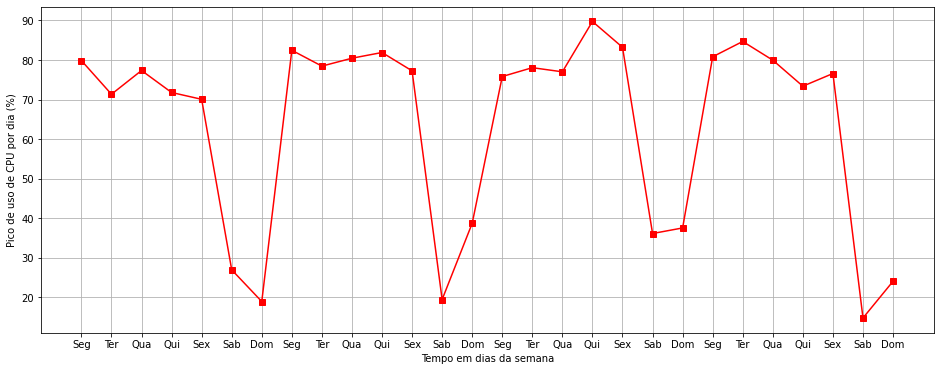

In [6]:
plt.figure(figsize=(16, 6))
plt.plot(vetor_tempo,semanal,'-s',color='red')
plt.xticks(np.arange(0, tempo_observado, 1), xticks_dias_da_semana)
# plt.title('Figura 11 - Componente Cíclico semanal com ruído')
plt.xlabel('Tempo em dias da semana')
plt.ylabel('Pico de uso de CPU por dia (%)')
plt.grid(True)
plt.savefig('Imagem-TCC-componente-ciclico-semanal-com-ruido-v3.pdf')

#### Figura 7 - Componente cíclico irregular semanal

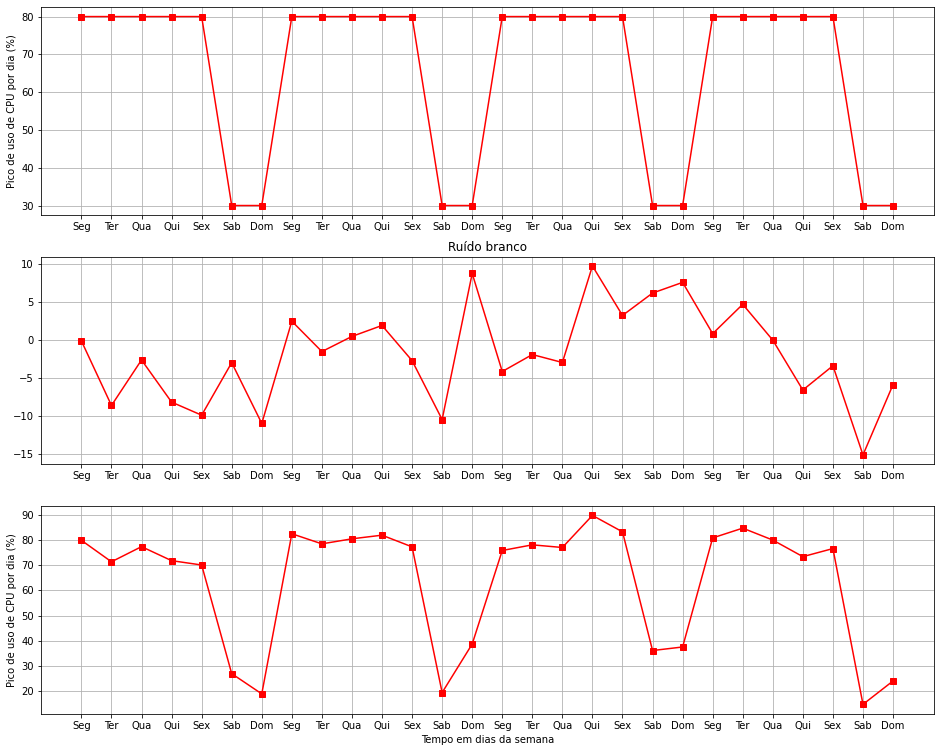

In [7]:
plt.figure(figsize=(16,13))
plt.subplot(311)
plt.plot(vetor_tempo,y1,'-s',color='red')
plt.xticks(np.arange(0, tempo_observado, 1), xticks_dias_da_semana)
plt.ylabel('Pico de uso de CPU por dia (%)')
plt.grid(True)
plt.subplot(312)
plt.plot(vetor_tempo,ruido,'-s',color='red')
plt.xticks(np.arange(0, tempo_observado, 1), xticks_dias_da_semana)
plt.title('Ruído branco')
plt.grid(True)
plt.subplot(313)
plt.plot(vetor_tempo,semanal,'-s',color='red')
plt.xticks(np.arange(0, tempo_observado, 1), xticks_dias_da_semana)
# plt.title('Figura 7 - Componente cíclico irregular semanal')
plt.xlabel('Tempo em dias da semana')
plt.ylabel('Pico de uso de CPU por dia (%)')
plt.grid(True)
plt.savefig('Imagem-TCC-componente-ciclico-irregular-semanal-v3.pdf')

### Composição da série temporal gerada

In [8]:
ano = 365 
dias_treino = 2*ano
dias_teste = 300 
dias_previsao = 90
tempo_observado2 = dias_treino + dias_teste + dias_previsao + 1 
vetor_tempo2 = np.arange(tempo_observado2)

In [9]:
y2 = np.zeros(tempo_observado2)
for i in range(0,tempo_observado2):
  if ((i % 7 - 5) == 0):
    y2[i] = 20
  elif ((i % 7 - 6) == 0):
    y2[i] = 20
  else:
    y2[i] = 60

In [10]:
semanal2 = y2 + np.random.normal(0,5,tempo_observado2) # Componente cíclico semanal com ruído aditivo

In [11]:
limiar_divisao = dias_treino + dias_teste # Treino e teste

In [12]:
freq1 = 1/ano
freq4 = 1/181
freq5 = 1/30
freq6 = 1/61
y = (np.cos(2*np.pi*freq1*vetor_tempo2)
     +np.cos(2*np.pi*freq4*vetor_tempo2)
     +np.cos(2*np.pi*freq5*vetor_tempo2)
     +np.cos(2*np.pi*freq6*vetor_tempo2))

#### Figura 8 - Componente de sazonalidade

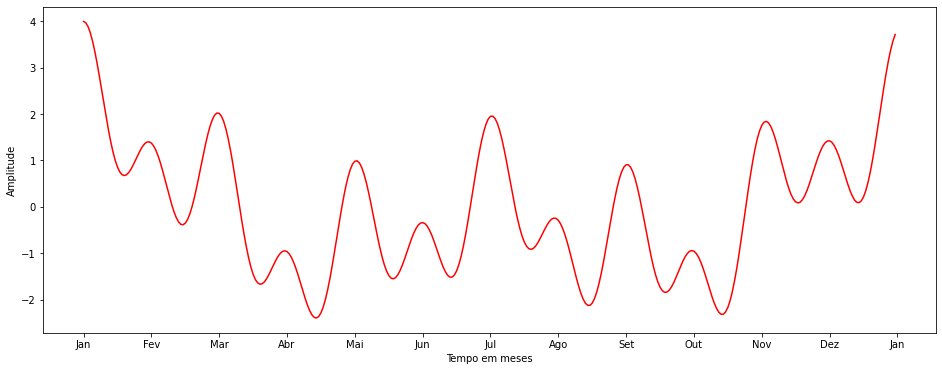

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(vetor_tempo2[:360],y[:360],color='red')
xticks_meses_do_ano = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez','Jan']
plt.xticks(np.arange(0, 365, 30), xticks_meses_do_ano)
plt.xlabel('Tempo em meses')
plt.ylabel('Amplitude')
plt.savefig('Imagem-TCC-componente-de-sazonalidade-meses-v3.pdf')

In [14]:
sazonalidade = 5*y + semanal2

In [15]:
# Generate a trend para. This will affect every element in an numpy array
def tendencia(vetor_tempo, inclinacao=0):
    return inclinacao * vetor_tempo2

In [16]:
inclinacao = 0.03

In [17]:
series = tendencia(vetor_tempo2, inclinacao) + sazonalidade

In [18]:
for i in range(limiar_divisao):
  if series[i] > 100:
    series[i] = 100

#### Figura 12 - Série Temporal Gerada e Divisão entre Treino e Teste

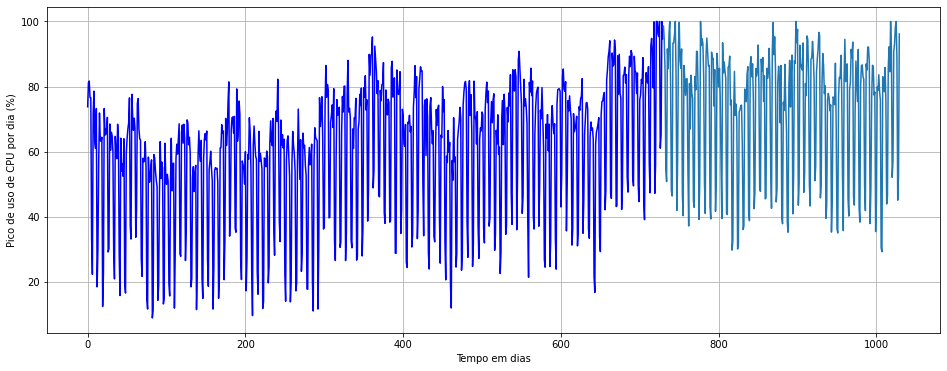

In [19]:
plt.figure(figsize=(16, 6))
plt.plot(vetor_tempo2[:dias_treino],series[:dias_treino],color='blue')
plt.plot(vetor_tempo2[dias_treino:limiar_divisao],series[dias_treino:limiar_divisao])
plt.xlabel('Tempo em dias')
plt.ylabel('Pico de uso de CPU por dia (%)')
plt.grid(True)
plt.savefig('Imagem-TCC-serie-temporal-gerada-divisao-treino-e-teste-v3.pdf')

#### Figura 9 - Componentes de uma série temporal e dados gerados

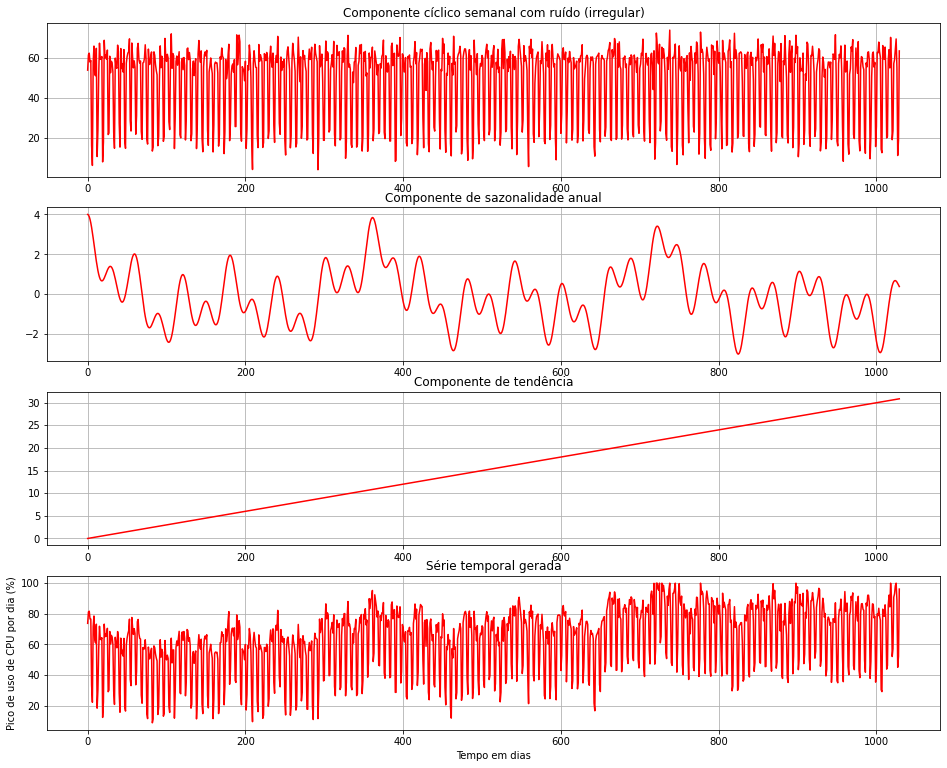

In [20]:
plt.figure(figsize=(16,13))
plt.subplot(411)
plt.plot(vetor_tempo2[:limiar_divisao],semanal2[:limiar_divisao],color='red')
plt.title('Componente cíclico semanal com ruído (irregular)')
plt.grid(True)
plt.subplot(412)
plt.plot(vetor_tempo2[:limiar_divisao],y[:limiar_divisao],color='red')
plt.title('Componente de sazonalidade anual')
plt.grid(True)
plt.subplot(413)
plt.plot(vetor_tempo2[:limiar_divisao],(tendencia(vetor_tempo2, inclinacao))[:limiar_divisao],color='red')
plt.title('Componente de tendência')
plt.grid(True)
plt.subplot(414)
plt.plot(vetor_tempo2[:limiar_divisao],series[:limiar_divisao],color='red')
plt.title('Série temporal gerada')
plt.grid(True)
plt.ylabel('Pico de uso de CPU por dia (%)')
plt.xlabel('Tempo em dias')
plt.savefig('Imagem-TCC-componentes-e-serie-temporal-gerada-v3.pdf')

## Regressão Linear

### Divisão em treino e teste

In [21]:
# Split the data into training and validation data and plot both
x_treino = vetor_tempo2[:dias_treino]
y_treino = series[:dias_treino]
x_teste = vetor_tempo2[dias_treino:limiar_divisao]
y_teste = series[dias_treino:limiar_divisao]

tempo_futuro_predito = vetor_tempo2[limiar_divisao:]

In [22]:
x_treino = x_treino.reshape(-1, 1)
y_treino = y_treino.reshape(-1, 1)
x_teste = x_teste.reshape(-1, 1)
y_teste = y_teste.reshape(-1, 1)

tempo_futuro_predito = tempo_futuro_predito.reshape(-1, 1)

### Treinamento do modelo

In [23]:
# Define um modelo de regressão
modelo_ols = linear_model.LinearRegression()

# Treina o modelo com os dados de treino
modelo_ols.fit(x_treino, y_treino)

LinearRegression()

### Predição da saída

In [24]:
y_predito_ols = modelo_ols.predict(x_teste)
y_treino_predito_ols = modelo_ols.predict(x_treino)
futuro_predito_ols = modelo_ols.predict(tempo_futuro_predito)

### Avaliação do modelo

Para saber o quanto o nosso modelo está explicando os dados, ou o quanto o modelo pode prever corretamente, iremos utilizar a medida R2, que é o coeficiente de determinação e o cálculo dos resíduos através da função custo (RMSE). Para isso iremos utilizar os dados da resposta na etapa de teste e os dados de resposta previstos.

In [25]:
# Calculo do RMSE e da pontuação R2 usando as funções do scikit-learn 
print('RMSE teste: %.4f' % (np.sqrt(mean_squared_error(y_teste, y_predito_ols))))
print('Medida R2: %.4f' % (r2_score(y_teste, y_predito_ols)))

RMSE teste: 20.2932
Medida R2: -0.0411


In [26]:
print('RMSE treino: %.4f' % (np.sqrt(mean_squared_error(y_treino,y_treino_predito_ols))))

RMSE treino: 19.9281


#### Figura 13 - Previsão utilizando regressão linear

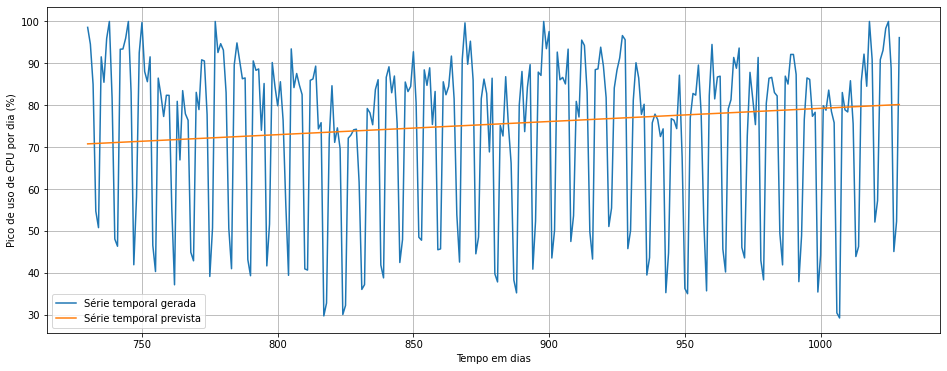

In [27]:
# plot baseline and predictions
plt.figure(figsize=(16, 6))
plt.plot(x_teste,y_teste, label='Série temporal gerada')
plt.plot(x_teste,y_predito_ols, label='Série temporal prevista')
plt.ylabel('Pico de uso de CPU por dia (%)')
plt.xlabel('Tempo em dias')
plt.legend()
plt.grid(True)
plt.savefig('Imagem-TCC-regressao-linear-v3.pdf')

## Rede Neural sem realimentação

### Pré-processamento dos dados para Rede Neural

In [28]:
data = pd.DataFrame(series)
dataset = data

In [29]:
# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [30]:
# Split the data into training and validation data and plot both
treino, teste, previsao = dataset[0:dias_treino,:], dataset[dias_treino:limiar_divisao,:], dataset[limiar_divisao:len(dataset),:]

In [31]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

### Configuração dos parâmetros para Rede Neural

In [32]:
seq_size = 10 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
treinoX, treinoY = to_sequences(treino, seq_size)
testeX, testeY = to_sequences(teste, seq_size)
previsaoX, previsaoY = to_sequences(previsao, seq_size)

#Compare trainX and dataset. You can see that X= values at t, t+1 and t+2
#whereas Y is the value that follows, t+3 (since our sequence size is 3)

print("Shape of training set: {}".format(treinoX.shape))
print("Shape of test set: {}".format(testeX.shape))
print("Shape of prediction set: {}".format(previsaoX.shape))

#Input dimensions are... (N x seq_size)
print('Build deep model...')
# create and fit dense model
modelo = Sequential()
modelo.add(Dense(64, input_dim=seq_size, activation='relu')) #12
modelo.add(Dense(32, activation='relu'))  #8
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(modelo.summary()) 

Shape of training set: (719, 10)
Shape of test set: (289, 10)
Shape of prediction set: (80, 10)
Build deep model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None


#### Figura 10 - Diagrama da Rede Neural Criada

In [53]:
from keras.utils.vis_utils import plot_model

plot_model(modelo, to_file='Imagem-TCC-diagrama-rede-neural-criada-v3.pdf', show_shapes=True, show_layer_names=True)

### Treinamento do modelo usando Rede Neural sem realimentação

In [34]:
history = modelo.fit(treinoX, treinoY, validation_data=(testeX, testeY), verbose=2, epochs=100)
history

Epoch 1/100
23/23 - 1s - loss: 0.0799 - acc: 0.0014 - val_loss: 0.0245 - val_acc: 0.0000e+00 - 1s/epoch - 50ms/step
Epoch 2/100
23/23 - 0s - loss: 0.0197 - acc: 0.0014 - val_loss: 0.0141 - val_acc: 0.0000e+00 - 87ms/epoch - 4ms/step
Epoch 3/100
23/23 - 0s - loss: 0.0121 - acc: 0.0014 - val_loss: 0.0086 - val_acc: 0.0000e+00 - 86ms/epoch - 4ms/step
Epoch 4/100
23/23 - 0s - loss: 0.0078 - acc: 0.0014 - val_loss: 0.0057 - val_acc: 0.0000e+00 - 85ms/epoch - 4ms/step
Epoch 5/100
23/23 - 0s - loss: 0.0060 - acc: 0.0014 - val_loss: 0.0053 - val_acc: 0.0000e+00 - 82ms/epoch - 4ms/step
Epoch 6/100
23/23 - 0s - loss: 0.0052 - acc: 0.0014 - val_loss: 0.0050 - val_acc: 0.0000e+00 - 87ms/epoch - 4ms/step
Epoch 7/100
23/23 - 0s - loss: 0.0047 - acc: 0.0014 - val_loss: 0.0046 - val_acc: 0.0000e+00 - 74ms/epoch - 3ms/step
Epoch 8/100
23/23 - 0s - loss: 0.0045 - acc: 0.0014 - val_loss: 0.0047 - val_acc: 0.0000e+00 - 82ms/epoch - 4ms/step
Epoch 9/100
23/23 - 0s - loss: 0.0045 - acc: 0.0014 - val_loss: 0

### Predição da saída usando Rede Neural sem realimentação

In [35]:
# make predictions

treinoPredito = modelo.predict(treinoX)
testePredito = modelo.predict(testeX)
previsaoPredito = modelo.predict(previsaoX)

3/3 [==============================] - 0s 4ms/step


In [36]:
# Estimate model performance
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

treinoPredito = scaler.inverse_transform(treinoPredito)
treinoY_inverso = scaler.inverse_transform([treinoY])
testePredito = scaler.inverse_transform(testePredito)
testeY_inverso = scaler.inverse_transform([testeY])
previsaoPredito = scaler.inverse_transform(previsaoPredito)

# calculate root mean squared error
treinoPontuacao = np.sqrt(mean_squared_error(treinoY_inverso[0], treinoPredito[:,0]))
print('Train Score: %.4f RMSE' % (treinoPontuacao))

testePontuacao = np.sqrt(mean_squared_error(testeY_inverso[0], testePredito[:,0]))
print('Test Score: %.4f RMSE' % (testePontuacao))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
treinoPreditoPlot = np.empty_like(dataset)
treinoPreditoPlot[:, :] = np.nan
treinoPreditoPlot[seq_size:len(treinoPredito)+seq_size, :] = treinoPredito

# shift test predictions for plotting
testePreditoPlot = np.empty_like(dataset)
testePreditoPlot[:, :] = np.nan
testePreditoPlot[len(treinoPredito)+(seq_size*2)+1:limiar_divisao-1, :] = testePredito

Train Score: 5.4498 RMSE
Test Score: 6.8540 RMSE


In [37]:
print('Medida R2: %.4f' % (r2_score(testeY_inverso[0], testePredito[:,0])))

Medida R2: 0.8811


#### Figura 14 - Previsão utilizando FNN para validação

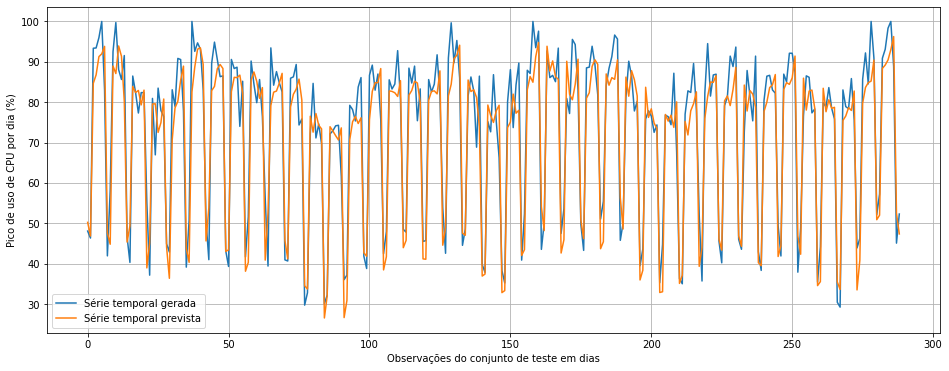

In [54]:
plt.figure(figsize=(16, 6))
plt.plot(testeY_inverso[0], label='Série temporal gerada')
plt.plot(testePredito[:,0], label='Série temporal prevista')
plt.ylabel('Pico de uso de CPU por dia (%)')
plt.xlabel('Observações do conjunto de teste em dias')
plt.legend()
plt.grid(True)
plt.savefig('Imagem-TCC-predicao-utilizando-RNN-v3.pdf')

#### Figura 15 - Previsão utilizando FNN

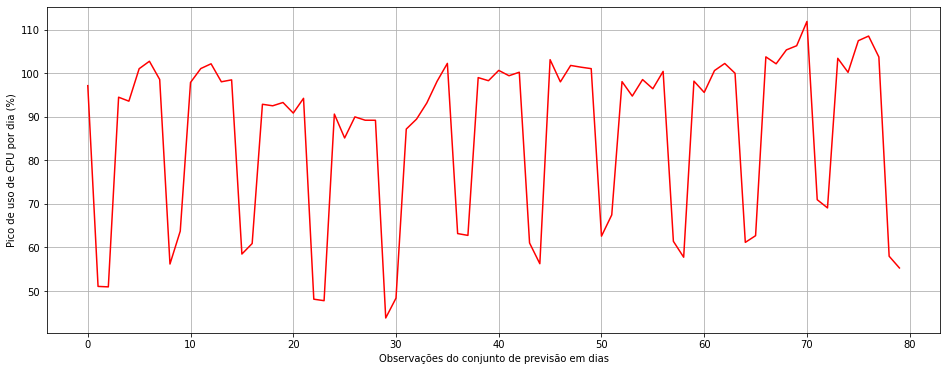

In [55]:
plt.figure(figsize=(16, 6))
plt.plot(previsaoPredito[:,0], 'r')
plt.ylabel('Pico de uso de CPU por dia (%)')
plt.xlabel('Observações do conjunto de previsão em dias')
plt.grid(True)
plt.savefig('Imagem-TCC-predicao-utilizando-RNN-90-dias-v3.pdf')